In [1]:
!pip uninstall -y spacy thinc

In [2]:
!pip install numpy==1.23.5

  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.23 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
xarray 2025.1.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
blosc2

In [3]:
!pip uninstall -y fastai


In [4]:
!pip install --quiet gensim==4.3.3 transformers

In [5]:
# Imports & Configuration

import os
import json
import random
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from gensim.models.fasttext import FastText


DATA_ROOT        = "/content/drive/MyDrive/VQA_Project/sample_data"
QUESTIONS_JSON   = os.path.join(DATA_ROOT, "questions",   "train2014_questions_subset.json")
ANNOTATIONS_JSON = os.path.join(DATA_ROOT, "annotations", "train2014_annotations_subset.json")
IMAGES_DIR       = os.path.join(DATA_ROOT, "images",      "train2014")
SUBSET_IDS_TXT   = os.path.join(DATA_ROOT, "subsets",     "train_subset_ids.txt")

# Hyperparameters (per the paper)
SEED        = 42
BATCH_SIZE  = 4      # small batches for FastText+BiLSTM
NUM_EPOCHS  = 10
LR          = 1e-3
TOP_ANSWERS = 1000

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reproducibility
random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

print(f"  Block 1 complete — DEVICE = {DEVICE}")
print(f"  Data root:       {DATA_ROOT}")
print(f"  Questions JSON:  {QUESTIONS_JSON}")
print(f"  Annotations JSON:{ANNOTATIONS_JSON}")
print(f"  Images dir:      {IMAGES_DIR}")


  Block 1 complete — DEVICE = cuda
  Data root:       /content/drive/MyDrive/VQA_Project/sample_data
  Questions JSON:  /content/drive/MyDrive/VQA_Project/sample_data/questions/train2014_questions_subset.json
  Annotations JSON:/content/drive/MyDrive/VQA_Project/sample_data/annotations/train2014_annotations_subset.json
  Images dir:      /content/drive/MyDrive/VQA_Project/sample_data/images/train2014


In [7]:
# Build `records` list & answer vocabulary

import json
from collections import Counter

# Load subset image-ID list
with open(SUBSET_IDS_TXT, "r") as f:
    subset_ids = set(int(line.strip()) for line in f)

# Load questions and annotations
with open(QUESTIONS_JSON, "r") as f:
    questions = json.load(f)["questions"]

with open(ANNOTATIONS_JSON, "r") as f:
    annotations = json.load(f)["annotations"]

# Map question_id → list of answers (lower-cased)
ans_map = {}
for ann in annotations:
    qid = ann["question_id"]
    ans_map.setdefault(qid, []).extend(a["answer"].lower() for a in ann["answers"])

# Build records list
records = []
for q in questions:
    qid, img_id = q["question_id"], q["image_id"]
    if img_id not in subset_ids or qid not in ans_map:
        continue
    img_file = f"COCO_train2014_{img_id:012d}.jpg"
    img_path = os.path.join(IMAGES_DIR, img_file)
    records.append({
        "image_path": img_path,
        "question":   q["question"],
        "answers":    ans_map[qid]
    })

print(f"Built {len(records):,} records")

# Build answer vocabulary (top 1000 answers + <unk>)
answer_counter = Counter(ans for rec in records for ans in rec["answers"])
top_answers    = answer_counter.most_common(TOP_ANSWERS)

answer_vocab = {ans: idx for idx, (ans, _) in enumerate(top_answers)}
answer_vocab["<unk>"] = len(answer_vocab)

print(f"Answer vocab size = {len(answer_vocab)} (top {TOP_ANSWERS} + <unk>)")


Built 15,000 records
Answer vocab size = 1001 (top 1000 + <unk>)


In [8]:
# FastText embeddings
import time, gensim
from gensim.utils import simple_preprocess
from gensim.models.fasttext import FastText

EMB_DIM   = 300                     # size of word vectors
FT_PATH   = "/content/fasttext_vqa.model"

# Try to load the big pretrained FastText model
use_pretrained = False
try:
    import gensim.downloader as api
    t0 = time.time()
    print("Attempting to load 'fasttext-wiki-news-subwords-300'…")
    ft_model = api.load("fasttext-wiki-news-subwords-300")   # ~1 GB
    use_pretrained = True
    print(f"Loaded pretrained FastText in {time.time()-t0:.1f}s")
except Exception as e:
    print("Could not load pretrained FastText (reason:", e, ")")
    print("Falling back to training a small model on the question corpus…")


# If pretrained load failed, train on our 15 K questions
if not use_pretrained:
    # Build tokenized sentences list
    sentences = [simple_preprocess(rec["question"]) for rec in records]

    print(f"Training FastText on {len(sentences):,} questions …")
    t0 = time.time()
    ft_model = FastText(
        vector_size = EMB_DIM,
        window      = 5,
        min_count   = 1,
        sg          = 1,          # skip-gram
        workers     = 4,
        epochs      = 10
    )
    ft_model.build_vocab(sentences)
    ft_model.train(sentences, total_examples=len(sentences), epochs=10)
    print(f"FastText trained in {time.time()-t0:.1f}s")

    # Save for reuse
    ft_model.save(FT_PATH)
    print(f"Model saved to {FT_PATH}")

# Sanity-check vector lookup (KeyedVectors vs. FastText)
def get_vec(model, token):
    # KeyedVectors already supports indexing: model["word"]
    try:
        return model[token]
    except TypeError:
        # If it's a FastText model (has .wv), use that
        return model.wv[token]

print("Embedding dim:", ft_model.vector_size)
print("Vector for 'dog'  →  first 5 values:", get_vec(ft_model, "dog")[:5])


Attempting to load 'fasttext-wiki-news-subwords-300'…
[==================================================] 100.0% 958.5/958.4MB downloaded
Loaded pretrained FastText in 324.9s
Embedding dim: 300
Vector for 'dog'  →  first 5 values: [-0.043178 -0.084789  0.058019 -0.03788  -0.076618]


In [9]:
# ONE-TIME feature extraction
import os, tqdm, torch
from torchvision import models, transforms
from PIL import Image

CACHE_PATH = "/content/drive/MyDrive/VQA_Project/sample_data/resnet101_feats.pt"

if os.path.exists(CACHE_PATH):
    print(" Feature cache already exists:", CACHE_PATH)
else:
    print("Extracting ResNet-101 features for all images …")

    # Frozen ResNet-101 backbone
    resnet = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V1)
    cnn = torch.nn.Sequential(*list(resnet.children())[:-1]).eval().to(DEVICE)
    for p in cnn.parameters():
        p.requires_grad = False

    tfm = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],
                             std =[0.229,0.224,0.225])
    ])

    feat_cache = {}
    with torch.no_grad():
        for rec in tqdm.tqdm(records, total=len(records)):
            img = Image.open(rec["image_path"]).convert("RGB")
            feat = cnn(tfm(img).unsqueeze(0).to(DEVICE)).squeeze().cpu()
            feat_cache[rec["image_path"]] = feat     # key: full image path

    torch.save(feat_cache, CACHE_PATH)
    print("Saved feature cache →", CACHE_PATH)


Extracting ResNet-101 features for all images …


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 159MB/s]
100%|██████████| 15000/15000 [40:33<00:00,  6.16it/s]


Saved feature cache → /content/drive/MyDrive/VQA_Project/sample_data/resnet101_feats.pt


In [10]:
# Dataset using cached features
import torch
from torch.utils.data import Dataset, DataLoader
from gensim.utils import simple_preprocess
from torch.nn.utils.rnn import pad_sequence
from collections import Counter

FEATS     = torch.load(CACHE_PATH)
EMB_DIM   = ft_model.vector_size            # 300
MAX_Q_LEN = 20

class VQADatasetFT(Dataset):
    def __init__(self, records, vocab, ft):
        self.records = records
        self.vocab   = vocab
        self.ft      = ft
        self.dim     = EMB_DIM
    def _vec(self, tok):
        return torch.from_numpy(self.ft[tok]) if tok in self.ft else torch.zeros(self.dim)
    def __len__(self): return len(self.records)
    def __getitem__(self, idx):
        rec   = self.records[idx]
        img_f = FEATS[rec["image_path"]]                # (2048,)
        toks  = simple_preprocess(rec["question"])[:MAX_Q_LEN]
        q_vec = torch.stack([self._vec(t) for t in toks])
        ans_i = self.vocab.get(Counter(rec["answers"]).most_common(1)[0][0],
                               self.vocab["<unk>"])
        return {"img_feat": img_f,
                "q_vecs" : q_vec,
                "q_len"  : q_vec.size(0),
                "answer" : torch.tensor(ans_i)}

def collate_fn(batch):
    img  = torch.stack([b["img_feat"] for b in batch])              # (B,2048)
    qlen = torch.tensor([b["q_len"] for b in batch])
    qpad = pad_sequence([b["q_vecs"] for b in batch],
                        batch_first=True)                           # (B,L,300)
    ans  = torch.stack([b["answer"] for b in batch])
    return {"img_feat": img, "q_vecs": qpad, "q_len": qlen, "answer": ans}

train_ds = VQADatasetFT(records, answer_vocab, ft_model)
train_dl = DataLoader(train_ds,
                      batch_size   = BATCH_SIZE,
                      shuffle      = True,
                      num_workers  = 2,
                      collate_fn   = collate_fn,
                      pin_memory   = True)

# sanity-check
b = next(iter(train_dl))
print("img_feat", b["img_feat"].shape,
      "| q_vecs",  b["q_vecs"].shape,
      "| answer",  b["answer"].shape)


<ipython-input-10-984d6816d7bb>:19: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(self.ft[tok]) if tok in self.ft else torch.zeros(self.dim)
<ipython-input-10-984d6816d7bb>:19: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
 

img_feat torch.Size([4, 2048]) | q_vecs torch.Size([4, 8, 300]) | answer torch.Size([4])


In [11]:
# Bi-LSTM + ResNet-101 fusion model

class BiLSTM_VQA(nn.Module):
    def __init__(self,
                 txt_emb_dim   = 300,
                 lstm_hidden   = 512,
                 img_feat_dim  = 2048,
                 fused_dim     = 1024,
                 num_answers   = len(answer_vocab)):
        super().__init__()

        # 2-layer bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size  = txt_emb_dim,
            hidden_size = lstm_hidden,
            num_layers  = 2,
            batch_first = True,
            bidirectional = True
        )

        # Project image feature to same dimension as question vector
        self.img_proj = nn.Linear(img_feat_dim, lstm_hidden * 2)

        # Fusion → element-wise multiplication, then 2-layer MLP
        self.fc1 = nn.Linear(lstm_hidden * 2, fused_dim)
        self.fc2 = nn.Linear(fused_dim, num_answers)

    def forward(self, img_feat, q_vecs, q_len):
        """
        img_feat : [B, 2048]
        q_vecs   : [B, L, 300]
        q_len    : [B]  (lengths before padding)
        """
        # Question encoder
        # Pack padded so LSTM ignores padding
        packed = nn.utils.rnn.pack_padded_sequence(
            q_vecs, q_len.cpu(), batch_first=True, enforce_sorted=False
        )
        _, (h_n, c_n) = self.lstm(packed)   # h_n: [num_layers*2, B, H]

        # Concatenate final hidden states of both directions (layer 2)
        # layer indexes: (layer0_fwd, layer0_bwd, layer1_fwd, layer1_bwd)
        fwd = h_n[-2]                       # [B, H]
        bwd = h_n[-1]                       # [B, H]
        q_vec = torch.cat([fwd, bwd], dim=1)  # [B, 2H]

        # Image projection
        img_vec = torch.tanh(self.img_proj(img_feat))  # [B, 2H]

        # Fusion (element-wise multiply)
        fused = img_vec * q_vec                       # [B, 2H]

        # Classification MLP
        x = torch.relu(self.fc1(fused))
        logits = self.fc2(x)
        return logits


In [13]:
# Training the Bi-LSTM–VQA model
from tqdm.auto import tqdm

model     = BiLSTM_VQA().to(DEVICE)                   # Initialize model on GPU/CPU
criterion = torch.nn.CrossEntropyLoss()              # Standard loss for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()                                     # Enable dropout, batch-norm, etc.
    tot_loss = tot_correct = n = 0                    # Reset metrics

    # Iterate batches with a progress bar
    for batch in tqdm(train_dl, desc=f"Epoch {epoch}/{NUM_EPOCHS}", leave=False):
        # Move inputs & labels to device
        img   = batch["img_feat"].to(DEVICE)
        q     = batch["q_vecs"].to(DEVICE)
        qlen  = batch["q_len"].to(DEVICE)
        ans   = batch["answer"].to(DEVICE)

        # Forward pass → raw logits
        logits = model(img, q, qlen)

        # Compute loss against true answer indices
        loss = criterion(logits, ans)

        # Backprop + parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss and count correct predictions
        tot_loss    += loss.item() * ans.size(0)
        tot_correct += (logits.argmax(1) == ans).sum().item()
        n           += ans.size(0)

    # Print epoch-level metrics
    print(
        f"Epoch {epoch}/{NUM_EPOCHS} | "
        f"Loss: {tot_loss/n:.4f} | Acc: {tot_correct/n:.4f}"
    )


<ipython-input-10-984d6816d7bb>:19: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(self.ft[tok]) if tok in self.ft else torch.zeros(self.dim)
<ipython-input-10-984d6816d7bb>:19: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
 

Epoch 1/10:   0%|          | 0/3750 [00:00<?, ?it/s]

<ipython-input-10-984d6816d7bb>:19: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(self.ft[tok]) if tok in self.ft else torch.zeros(self.dim)
<ipython-input-10-984d6816d7bb>:19: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
 

Epoch 1/10 | Loss: 3.1799 | Acc: 0.3716


<ipython-input-10-984d6816d7bb>:19: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(self.ft[tok]) if tok in self.ft else torch.zeros(self.dim)
<ipython-input-10-984d6816d7bb>:19: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
 

Epoch 2/10:   0%|          | 0/3750 [00:00<?, ?it/s]

<ipython-input-10-984d6816d7bb>:19: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(self.ft[tok]) if tok in self.ft else torch.zeros(self.dim)
<ipython-input-10-984d6816d7bb>:19: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
 

Epoch 2/10 | Loss: 2.8574 | Acc: 0.3901


<ipython-input-10-984d6816d7bb>:19: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(self.ft[tok]) if tok in self.ft else torch.zeros(self.dim)
<ipython-input-10-984d6816d7bb>:19: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
 

Epoch 3/10:   0%|          | 0/3750 [00:00<?, ?it/s]

<ipython-input-10-984d6816d7bb>:19: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(self.ft[tok]) if tok in self.ft else torch.zeros(self.dim)
<ipython-input-10-984d6816d7bb>:19: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
 

Epoch 3/10 | Loss: 2.7392 | Acc: 0.3942


<ipython-input-10-984d6816d7bb>:19: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(self.ft[tok]) if tok in self.ft else torch.zeros(self.dim)


Epoch 4/10:   0%|          | 0/3750 [00:00<?, ?it/s]

<ipython-input-10-984d6816d7bb>:19: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(self.ft[tok]) if tok in self.ft else torch.zeros(self.dim)
<ipython-input-10-984d6816d7bb>:19: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
 

Epoch 4/10 | Loss: 2.6422 | Acc: 0.3979


<ipython-input-10-984d6816d7bb>:19: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(self.ft[tok]) if tok in self.ft else torch.zeros(self.dim)
<ipython-input-10-984d6816d7bb>:19: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
 

Epoch 5/10:   0%|          | 0/3750 [00:00<?, ?it/s]

<ipython-input-10-984d6816d7bb>:19: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(self.ft[tok]) if tok in self.ft else torch.zeros(self.dim)
<ipython-input-10-984d6816d7bb>:19: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
 

Epoch 5/10 | Loss: 2.5483 | Acc: 0.4052


<ipython-input-10-984d6816d7bb>:19: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(self.ft[tok]) if tok in self.ft else torch.zeros(self.dim)


Epoch 6/10:   0%|          | 0/3750 [00:00<?, ?it/s]

<ipython-input-10-984d6816d7bb>:19: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(self.ft[tok]) if tok in self.ft else torch.zeros(self.dim)
<ipython-input-10-984d6816d7bb>:19: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
 

Epoch 6/10 | Loss: 2.4592 | Acc: 0.4111


<ipython-input-10-984d6816d7bb>:19: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(self.ft[tok]) if tok in self.ft else torch.zeros(self.dim)


Epoch 7/10:   0%|          | 0/3750 [00:00<?, ?it/s]

<ipython-input-10-984d6816d7bb>:19: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(self.ft[tok]) if tok in self.ft else torch.zeros(self.dim)
<ipython-input-10-984d6816d7bb>:19: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
 

Epoch 7/10 | Loss: 2.3627 | Acc: 0.4198


<ipython-input-10-984d6816d7bb>:19: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(self.ft[tok]) if tok in self.ft else torch.zeros(self.dim)


Epoch 8/10:   0%|          | 0/3750 [00:00<?, ?it/s]

<ipython-input-10-984d6816d7bb>:19: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(self.ft[tok]) if tok in self.ft else torch.zeros(self.dim)
<ipython-input-10-984d6816d7bb>:19: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
 

Epoch 8/10 | Loss: 2.2705 | Acc: 0.4282


<ipython-input-10-984d6816d7bb>:19: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(self.ft[tok]) if tok in self.ft else torch.zeros(self.dim)


Epoch 9/10:   0%|          | 0/3750 [00:00<?, ?it/s]

<ipython-input-10-984d6816d7bb>:19: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(self.ft[tok]) if tok in self.ft else torch.zeros(self.dim)
<ipython-input-10-984d6816d7bb>:19: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
 

Epoch 9/10 | Loss: 2.1735 | Acc: 0.4398


<ipython-input-10-984d6816d7bb>:19: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(self.ft[tok]) if tok in self.ft else torch.zeros(self.dim)
<ipython-input-10-984d6816d7bb>:19: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
 

Epoch 10/10:   0%|          | 0/3750 [00:00<?, ?it/s]

<ipython-input-10-984d6816d7bb>:19: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(self.ft[tok]) if tok in self.ft else torch.zeros(self.dim)
<ipython-input-10-984d6816d7bb>:19: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
 

Epoch 10/10 | Loss: 2.0840 | Acc: 0.4526


In [14]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

# Return most frequent answer
def maj_answer(answers):
    """return the most frequent string among 10 GT answers"""
    return Counter(answers).most_common(1)[0][0]

# Batch prediction function for a list of records using a custom model
def predict_batch(recs):
    """run model on a list of record dicts, return list of preds"""
    model.eval()
    out = []
    with torch.no_grad():
        for rec in recs:
            img_f = FEATS[rec["image_path"]].unsqueeze(0).to(DEVICE)
            toks  = simple_preprocess(rec["question"])[:MAX_Q_LEN]
            q_vec = torch.stack([torch.from_numpy(ft_model[w])
                                 if w in ft_model else torch.zeros(EMB_DIM)
                                 for w in toks]).unsqueeze(0).to(DEVICE)
            q_len = torch.tensor([q_vec.size(1)], device=DEVICE)
            logits = model(img_f, q_vec, q_len)
            pred_idx = logits.argmax(1).item()
            pred_ans = inv_vocab[pred_idx]   # build once below
            out.append(pred_ans)
    return out

# build reverse vocab for id → answer
inv_vocab = {idx: ans for ans, idx in answer_vocab.items()}
print("helper functions ready")


helper functions ready


Predict all:   0%|          | 0/15000 [00:00<?, ?it/s]

<ipython-input-16-e3a48721d86e>:16: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  q_vec = torch.stack([torch.from_numpy(ft_model[w])


Top-5 question types by accuracy:


,qtype,acc,total
33,could this,95.833333,24
10,is there,78.787879,561
32,are all,76.595745,47
52,do the,76.190476,42
9,can you,76.119403,67



Bottom-5 question types:


,qtype,acc,total
49,what colors,0.0,29
23,why is,0.0,102
51,what fruit,0.0,20
36,where are,0.0,97
29,where was,0.0,34



 HIGH-ACCURACY EXAMPLES


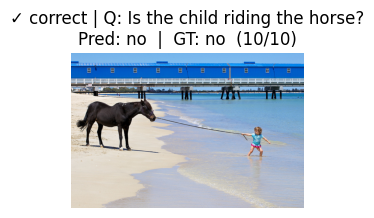

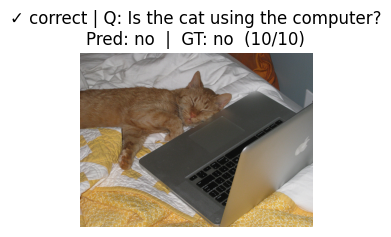

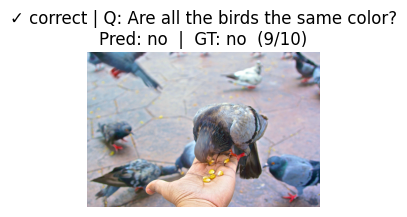


 LOW-ACCURACY EXAMPLES


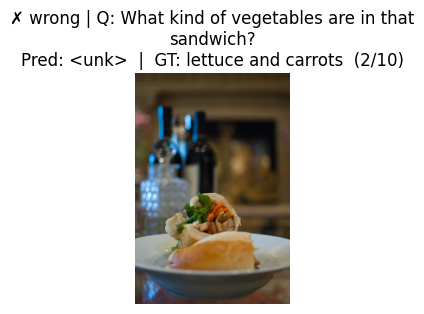

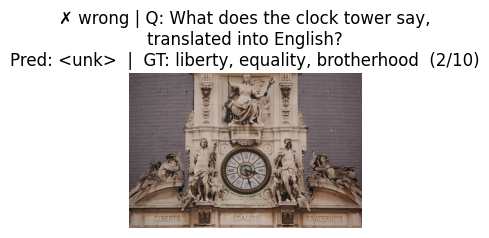

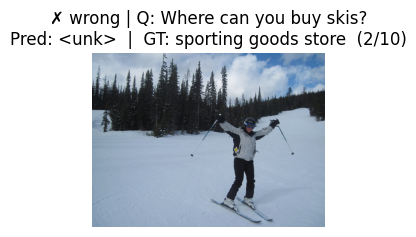

In [16]:
# Per-type accuracy + high / low examples
import pandas as pd, random, textwrap, matplotlib.pyplot as plt
from collections import Counter, defaultdict
from tqdm.auto import tqdm

def maj_answer(answers):           # majority answer among annotators
    return Counter(answers).most_common(1)[0][0]

def first_two_words(q):
    toks = q.lower().split()
    return " ".join(toks[:2]) if len(toks) >= 2 else toks[0]

def predict(record):
    img_f = FEATS[record["image_path"]].unsqueeze(0).to(DEVICE)
    toks  = simple_preprocess(record["question"])[:MAX_Q_LEN]
    q_vec = torch.stack([torch.from_numpy(ft_model[w])
                         if w in ft_model else torch.zeros(EMB_DIM)
                         for w in toks]).unsqueeze(0).to(DEVICE)
    q_len = torch.tensor([q_vec.size(1)], device=DEVICE)
    with torch.no_grad():
        logit = model(img_f, q_vec, q_len)
    return inv_vocab[logit.argmax(1).item()]

# pass 1: compute correctness per record
records_eval = []
for rec in tqdm(records, desc="Predict all"):
    pred = predict(rec)
    gt   = maj_answer(rec["answers"])
    correct = pred == gt
    qtype = first_two_words(rec["question"])
    annot_count = Counter(rec["answers"])[gt]   # how many annotators agreed
    records_eval.append({
        "qtype": qtype,
        "correct": correct,
        "img": rec["image_path"],
        "question": rec["question"],
        "pred": pred,
        "gt": gt,
        "agree": annot_count
    })

# pass 2: per-type stats
stats = defaultdict(lambda: [0,0])   # [correct, total]
for r in records_eval:
    stats[r["qtype"]][1] += 1
    if r["correct"]:
        stats[r["qtype"]][0] += 1

type_rows = [{"qtype": t,
              "acc": 100* c/tot,
              "total": tot}
             for t,(c,tot) in stats.items() if tot>=20]  # ignore tiny counts
df = pd.DataFrame(type_rows).sort_values("acc", ascending=False)

print("Top-5 question types by accuracy:")
display(df.head(5)[["qtype","acc","total"]])

print("\nBottom-5 question types:")
display(df.tail(5)[["qtype","acc","total"]])

# pick 3 high-accuracy examples
high = [r for r in records_eval if r["correct"] and r["agree"]>=6]
low  = [r for r in records_eval if not r["correct"] and r["agree"]<=3]
random.seed(0)
high_ex = random.sample(high, 3)
low_ex  = random.sample(low, 3)

def show(row, tag):
    plt.figure(figsize=(3,3))
    plt.imshow(Image.open(row["img"])); plt.axis("off")
    title = textwrap.fill(row["question"], 38)
    plt.title(f'{tag} | Q: {title}\n'
              f'Pred: {row["pred"]}  |  GT: {row["gt"]}  '
              f'({row["agree"]}/10)')
    plt.show()

print("\n HIGH-ACCURACY EXAMPLES")
for r in high_ex: show(r,"✓ correct")

print("\n LOW-ACCURACY EXAMPLES")
for r in low_ex:  show(r,"✗ wrong")


In [17]:
# Evaluation Block  (Top-1 + VQA-soft)
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch, tqdm

# majority ground-truth answer
def maj_answer(ans_list):
    return Counter([a.lower() for a in ans_list]).most_common(1)[0][0]

# official VQA soft-score
def vqa_soft_score(pred, ans_list):
    agree = sum(pred.lower() == a.lower() for a in ans_list)
    return min(1.0, agree / 3.0)

# EvalDataset that keeps answer list
class EvalDataset(Dataset):
    def __init__(self, recs):
        self.recs = recs
    def _vec(self, tok):
        return (torch.from_numpy(ft_model[tok])
                if tok in ft_model else torch.zeros(EMB_DIM))
    def __len__(self): return len(self.recs)
    def __getitem__(self, idx):
        rec   = self.recs[idx]
        toks  = simple_preprocess(rec["question"])[:MAX_Q_LEN]
        qvec  = torch.stack([self._vec(t) for t in toks])
        return {
            "img_feat": FEATS[rec["image_path"]],   # tensor(2048)
            "q_vecs" : qvec,                        # (L,300)
            "q_len"  : qvec.size(0),
            "answers": rec["answers"]               # full list of 10 GT answers
        }

def collate_eval(batch):
    img  = torch.stack([b["img_feat"] for b in batch])
    qlen = torch.tensor([b["q_len"] for b in batch])
    qpad = pad_sequence([b["q_vecs"] for b in batch], batch_first=True)
    ans  = [b["answers"] for b in batch]
    return {"img_feat": img, "q_vecs": qpad, "q_len": qlen, "answers": ans}

eval_dl = DataLoader(EvalDataset(records),
                     batch_size = 64,
                     shuffle    = False,
                     num_workers= 2,
                     collate_fn = collate_eval,
                     pin_memory = True)

# evaluation loop
def evaluate(loader):
    model.eval()
    hard = soft = n = 0
    with torch.no_grad():
        for batch in tqdm.tqdm(loader, desc="Eval"):
            logits = model(batch["img_feat"].to(DEVICE),
                           batch["q_vecs"].to(DEVICE),
                           batch["q_len"].to(DEVICE))
            preds = [inv_vocab[i] for i in logits.argmax(1).cpu().tolist()]
            for p, ans_list in zip(preds, batch["answers"]):
                hard += (p.lower() == maj_answer(ans_list))
                soft += vqa_soft_score(p, ans_list)
            n += len(preds)
    return hard/n, soft/n

top1, vqa = evaluate(eval_dl)
print(f"Top-1 accuracy : {top1:.4f}")
print(f"VQA-soft acc  : {vqa:.4f}")


Eval: 100%|██████████| 235/235 [00:02<00:00, 107.92it/s]

Top-1 accuracy : 0.3663
VQA-soft acc  : 0.4173


In [18]:
# Per-question-type accuracy table
import re, pandas as pd
from collections import defaultdict
from gensim.utils import simple_preprocess
from tqdm.auto import tqdm

# helper to get first-two-word prefix
def qtype(question: str) -> str:
    tok = re.findall(r"\w+", question.lower())
    return " ".join(tok[:2]) if len(tok) >= 2 else tok[0]

# cache predictions to avoid recompute if you rerun the cell
if "pred_cache" not in globals():
    print("⏳  Running model on every record …")
    pred_cache = []
    model.eval()
    with torch.no_grad():
        for rec in tqdm(records):
            # build image feature tensor (already cached)
            img_feat = FEATS[rec["image_path"]].unsqueeze(0).to(DEVICE)
            # question to FastText tensor
            toks = simple_preprocess(rec["question"])[:MAX_Q_LEN]
            q_vec = torch.stack([
                torch.from_numpy(ft_model[t]) if t in ft_model else torch.zeros(EMB_DIM)
                for t in toks]).unsqueeze(0).to(DEVICE)
            q_len = torch.tensor([q_vec.size(1)], device=DEVICE)
            # forward
            pred_idx = model(img_feat, q_vec, q_len).argmax(1).item()
            pred_cache.append(inv_vocab[pred_idx])

stats = defaultdict(lambda: [0, 0])   # [correct, total]

for rec, pred in zip(records, pred_cache):
    qt = qtype(rec["question"])
    stats[qt][1] += 1
    if pred.lower() == maj_answer(rec["answers"]):
        stats[qt][0] += 1

rows = [{"qtype": qt,
         "acc%": 100 * correct / total,
         "count": total}
        for qt, (correct, total) in stats.items() if total >= 20]

df = pd.DataFrame(rows).sort_values("acc%", ascending=False)

print("  Top-5 question types")
display(df.head(5).style.format({"acc%": "{:.1f}"}))

print("\n  Bottom-5 question types")
display(df.tail(5).style.format({"acc%": "{:.1f}"}))


⏳  Running model on every record …


  0%|          | 0/15000 [00:00<?, ?it/s]

  Top-5 question types


,qtype,acc%,count
33,could this,95.8,24
10,is there,78.8,561
32,are all,76.6,47
53,do the,76.2,42
9,can you,76.1,67



  Bottom-5 question types


,qtype,acc%,count
50,what colors,0.0,29
23,why is,0.0,102
52,what fruit,0.0,20
37,where are,0.0,97
29,where was,0.0,34
